## CIFAR 10

In [13]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [14]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [11]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32
workers=7

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

def torch_loader(data_path, size):
    if not os.path.exists(data_path+'/train'): download_cifar10(data_path)

    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    tfms = [transforms.ToTensor(), normalize]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, val_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [5]:
data = torch_loader(str(PATH), sz)

In [6]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,.9), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=7, lr=(.9,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=3, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.66526    2.344898   0.3635    
    1      1.256508   1.369473   0.5592                   
    2      0.968212   0.942512   0.68                      
    3      0.793817   0.729841   0.7539                    
    4      0.674234   0.947319   0.6872                    
    5      0.572293   0.571005   0.8089                    
    6      0.505574   0.708097   0.7542                    
    7      0.4773     0.544679   0.8225                    
    8      0.427297   0.603911   0.8046                    
    9      0.399874   0.589722   0.8057                    
    10     0.366514   0.5199     0.8297                    
    11     0.325982   0.420317   0.8652                    
    12     0.30127    0.41153    0.8659                    
    13     0.273297   0.43807    0.8577                    
    14     0.237144   0.404576   0.8735                    
    15     0.187449   0.327712   0.8949                   

[array([0.22083]), 0.9299999996185303]

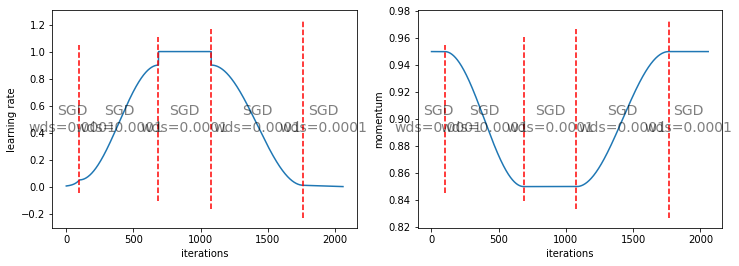

In [7]:
learn.sched.plot_lr()

In [8]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 4e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,1.1), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1.1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=8, lr=(1.1,.005), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=2, lr=(.005,.001), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.752474   2.304783   0.3772    
    1      1.371828   1.583727   0.5268                   
    2      1.046365   1.224758   0.5657                   
    3      0.829661   1.096694   0.6638                    
    4      0.71493    0.821677   0.7263                    
    5      0.611736   0.973354   0.7029                    
    6      0.553251   0.939936   0.7246                    
    7      0.491462   0.540346   0.8178                    
    8      0.43213    0.542638   0.8228                    
    9      0.403893   0.666512   0.7979                    
    10     0.383776   0.434796   0.8594                    
    11     0.350318   0.548883   0.8077                    
    12     0.331349   0.580524   0.8119                    
    13     0.300143   0.628482   0.8139                    
    14     0.276342   0.409791   0.8613                    
    15     0.232132   0.358471   0.8831                    

[array([0.2275]), 0.9298000014305114]

In [12]:
# no activation scale
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 4e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,1.1), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1.1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=8, lr=(1.1,.005), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=2, lr=.005, lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.698742   3.318098   0.2957    
    1      1.39156    5.488825   0.2282                   
    2      1.13915    4.938947   0.2921                   
    3      0.956944   1.458462   0.5873                    
    4      0.841631   1.758545   0.5123                    
    5      0.741075   1.131309   0.6443                    
    6      0.694246   0.790346   0.7156                    
    7      0.613475   0.840255   0.7138                    
    8      0.556079   0.957055   0.6973                    
    9      0.517534   0.84307    0.7226                    
    10     0.482407   0.839548   0.7301                    
    11     0.444594   0.615213   0.7984                    
    12     0.420339   0.515712   0.833                     
    13     0.381753   0.854218   0.7614                    
    14     0.339466   0.488028   0.8387                    
    15     0.290371   0.358797   0.8792                    

[array([0.25173]), 0.9204000014305115]

In [15]:
# .1 activation scale
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 4e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,1.1), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1.1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=8, lr=(1.1,.005), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=2, lr=.005, lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.798473   1.817656   0.4346    
    1      1.368729   1.164998   0.5741                   
    2      1.068805   1.328745   0.5696                   
    3      0.890238   0.895416   0.7002                    
    4      0.785421   0.873376   0.7218                    
    5      0.692066   0.687858   0.7767                    
    6      0.623326   1.642933   0.5986                    
    7      0.545686   0.886243   0.7189                    
    8      0.48887    0.896244   0.7089                    
    9      0.474913   0.776356   0.7388                    
    10     0.439363   0.771902   0.7774                    
    11     0.404382   0.683753   0.7853                    
    12     0.388181   0.654763   0.7879                    
    13     0.355072   0.564786   0.8181                    
    14     0.314632   0.427668   0.8609                    
    15     0.26979    0.404981   0.866                     

[array([0.24044]), 0.9233999994277954]

In [16]:
# .1 activation scale
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 4e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,1.1), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1.1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=8, lr=(1.1,.005), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=2, lr=(.005,.0001), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.614084   1.880414   0.4276    
    1      1.221256   1.767457   0.5128                   
    2      0.940032   1.793488   0.5089                    
    3      0.760124   0.893531   0.7065                    
    4      0.659536   0.944209   0.6896                    
    5      0.580415   0.741552   0.7622                    
    6      0.493304   0.700595   0.7717                    
    7      0.459025   0.735491   0.7542                    
    8      0.397764   0.540741   0.8281                    
    9      0.374453   0.633014   0.7941                    
    10     0.359072   0.479243   0.8404                    
    11     0.338738   0.494119   0.8393                    
    12     0.303266   0.468642   0.8507                    
    13     0.27293    0.386538   0.8746                    
    14     0.238623   0.452832   0.8668                    
    15     0.204306   0.312487   0.8977                   

[array([0.22106]), 0.9354000012397766]

In [19]:
# .1 activation scale
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.009,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,1.3), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1.3, momentum=0.85),
    TrainingPhase(**def_phase, epochs=9, lr=(1.3,.005), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=2, lr=(.005,.0001), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

 17%|█▋        | 17/98 [00:02<00:13,  5.95it/s, loss=2.12]

Exception in thread Thread-324:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.541104   1.837962   0.445     
    1      1.17998    1.279517   0.598                    
    2      0.917544   1.301177   0.6069                    
    3      0.738803   0.999455   0.6783                    
    4      0.645763   0.836284   0.7311                    
    5      0.583209   0.699085   0.7677                    
    6      0.508644   1.113309   0.6438                    
    7      0.462904   0.554062   0.8141                    
    8      0.414427   0.564348   0.8051                    
    9      0.394017   0.636807   0.7999                    
    10     0.370853   0.652487   0.7936                    
    11     0.349361   0.565336   0.814                     
    12     0.330728   0.486724   0.8316                    
    13     0.307535   0.458229   0.8504                    
    14     0.273573   0.571538   0.8341                    
    15     0.239782   0.389116   0.8742                   

[array([0.21749]), 0.9340999990463257]

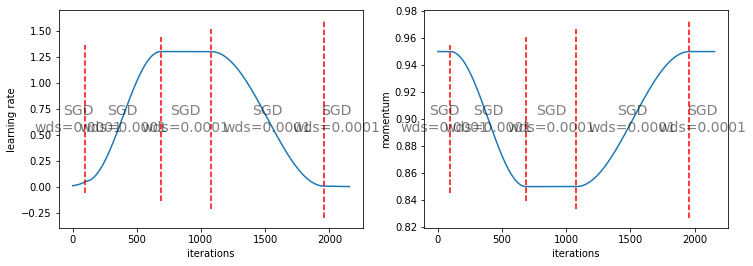

In [21]:
learn.sched.plot_lr()